You need to implement Logistic Regression from scratch in this question

1. You are provided with the dataset of sign language digits. Implement logistic regression from scratch to classify the images provided in the dataset. Load the dataset and perform splitting into training and test sets with 70:30 ratio randomly using test train split.
2. Plot a diagram for the sigmoid function. This is used for binary classi cation. How do you modify it for multilabel dataset classification problems? State and Explain the methods used.
3. Use both one vs all and one vs one method for the above problem statement purpose.
4. Also get results using Log Reg from scikit learn.
5. Report accuracy score, Confusion matrix and any other metrics you feel useful and Compare the results - from all the three.



[BONUS]
6. Display few pictures with their predicted and original labels 
7. Do the results differ? State the reasons why it is so.


dataset link : 
https://iiitaphyd-my.sharepoint.com/:f:/g/personal/apurva_jadhav_students_iiit_ac_in/Eictt5_qmoxNqezgQQiMWeIBph4sxlfA6jWAJNPnV2SF9Q?e=mQmYN0 

                

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMAI/Assignment2/q_datasets
!pwd
!ls

Mounted at /content/drive
/content/drive/MyDrive/SMAI/Assignment2/q_datasets
/content/drive/MyDrive/SMAI/Assignment2/q_datasets
'archive (1).zip'   fashion_mnist   titanic.csv   X.npy   Y.npy


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [3]:
X_org = np.load("X.npy") # image
y_org = np.load("Y.npy") # label

print(X_org.shape)
print(y_org.shape)

X_org = X_org.reshape(X_org.shape[0],-1)

print(X_org.shape)
print(y_org.shape)


(2062, 64, 64)
(2062, 10)
(2062, 4096)
(2062, 10)


In [4]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X_org, y_org, test_size=0.30,random_state=1)

print(X_train_org.shape)
print(y_train.shape)
print(X_test_org.shape)
print(y_test.shape)

y_train_lab = np.argmax(y_train, axis=1) 
print(y_train_lab.shape)
print(np.unique(y_train_lab))
y_test_lab = np.argmax(y_test, axis=1) 
print(y_test_lab.shape)
print(np.unique(y_test_lab))

(1443, 4096)
(1443, 10)
(619, 4096)
(619, 10)
(1443,)
[0 1 2 3 4 5 6 7 8 9]
(619,)
[0 1 2 3 4 5 6 7 8 9]


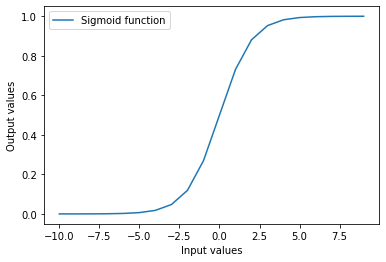

In [5]:
sigs = []
m = 10
for i in range(-m,m):
    sigs.append(1 / (1 + np.exp(-i)))
plt.plot(range(-m,m), sigs, label='Sigmoid function')
plt.xlabel('Input values')
plt.ylabel('Output values')
plt.legend()
plt.show()

Sigmoid function is used for Binary classification, eg: input belongs to class A if sigmoid(Z) > 0.5 else it belongs to class B.   For multi-class classification, we follow two methods: 1) One vs One, Or 2) One vs All

1) One vs One:  
We train different models for each pair of classes. While training we consider set of rows belonging to 2 classes at a time and eliminate rows of other classes. The model is trained to classify for eg class A vs class B. Similarly we train models for other pairs of classes, so we get in total C(C-1)/2 models. While testing, we pass the test row through all the models and keep adding sigmoid probabilities for the respective classes. After all models are used, we predict the class with maximum score for that row.  
  
2) One vs All:
We train different models for each class, eg: class A vs All other classes. Ie, if sigmoid(Z) > 0.5, the row belongs to class A else does not belong to class A. So we get C different models for each class. While testing, each test input row is passed through each of the C models and obtain sigmoid score for each class. The class having maximum score is predicted for that row.

In [6]:
# Normalizing the image pixel values
X_norm_train = X_train_org - np.mean(X_train_org)
X_norm_test = X_test_org - np.mean(X_test_org)

In [7]:
class MyLogRegressor(object):
    def __init__(self, lr=0.2, itrs=100):
        self.lr = lr 
        self.itrs = itrs
        self.W = []
        self.cost = []
        self.method = None
    
    def fit_onevsall(self, X, Y):
        self.method = 'onevsall'
        X = np.insert(X, 0, 1, axis=1)
        n = len(Y)
        for i in np.unique(Y):
            print('Training:',i,'vs All')
            W = np.zeros(X.shape[1])
            cost = []
            Y_ovr = np.where(Y == i, 1, 0)
            for _ in range(self.itrs):
                Z = X.dot(W)
                H = self.sigmoid(Z)
                W = self.gradient_desc(X,H,W,Y_ovr,n)
                cost.append(self.cal_cost(H,W,Y_ovr)) 
            self.W.append((i, W))
            self.cost.append((i,cost))
        return self

    def fit_onevsone(self, X, Y):
        self.method = 'onevsone'
        X = np.insert(X, 0, 1, axis=1)
        n = len(Y)
        Y_unq = np.unique(Y)
        m = 0
        for i in range(10):
            for j in range(i+1,10):
                if i==j:
                    continue
                print('Training model',m,':',i,'vs',j)
                # print(len(np.where(Y==i)[0]),len(np.where(Y==j)[0])
                mask = (Y==i) | (Y==j)
                Ynew = Y[mask]
                # print(len(Ynew))
                Xnew = X[mask]
                W = np.zeros(X.shape[1])
                cost = []
                Y_ovo = np.where(Ynew == i, 1, 0)
                for _ in range(self.itrs):
                    Z = Xnew.dot(W)
                    H = self.sigmoid(Z)
                    W = self.gradient_desc(Xnew,H,W,Y_ovo,n)
                    cost.append(self.cal_cost(H,W,Y_ovo)) 
                self.W.append((i,j, W))
                self.cost.append((i,j,cost))
                m += 1
        return self

    def gradient_desc(self,X,H,W,Y,n):
        gradient = np.dot(X.T, (H - Y)) / n
        W = W - self.lr * gradient
        return W 

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def cal_cost(self,H,W,Y):
        n = len(Y)
        cost = (np.sum(-Y.T.dot(np.log(H)) - (1 - Y).T.dot(np.log(1 - H)))) / n
        return cost

    def predict_ovr(self, X):
        X = np.insert(X, 0, 1, axis=1)
        Y_pred = [max((self.sigmoid(i.dot(W)), c) for c, W in self.W)[1] for i in X ]
        return Y_pred

    def predict_ovo(self, X):
        X = np.insert(X, 0, 1, axis=1)
        Y_pred = []
        for x in X:
            y_arr = [0 for j in range(10)]
            for c1, c2, W in self.W:
                res = self.sigmoid(x.dot(W))
                y_arr[c1] += res
                y_arr[c2] += 1-res
            Y_pred.append(y_arr.index(max(y_arr)))
        return Y_pred

    def cal_score_ovr(self,X, Y):
        score = sum(self.predict_ovr(X) == Y) / len(Y)
        return score

    def cal_score_ovo(self,X, Y):
        score = sum(self.predict_ovo(X) == Y) / len(Y)
        return score
    
    def plot_cost_ovr(self): 
        for c,cost in self.cost:
            plt.plot(range(self.itrs), cost, label=str(c)+" vs All")
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Convergence Graph of Cost Function')
        plt.legend()
        plt.show()

    def plot_cost_ovo(self): 
        for c1,c2,cost in self.cost:
            plt.plot(range(self.itrs), cost, label=str(c1)+" vs "+str(c2))
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Convergence Graph of Cost Function')
        # plt.legend()
        plt.show()

One vs All: Score and confusion matrix of training set

Training: 0 vs All
Training: 1 vs All
Training: 2 vs All
Training: 3 vs All
Training: 4 vs All
Training: 5 vs All
Training: 6 vs All
Training: 7 vs All
Training: 8 vs All
Training: 9 vs All


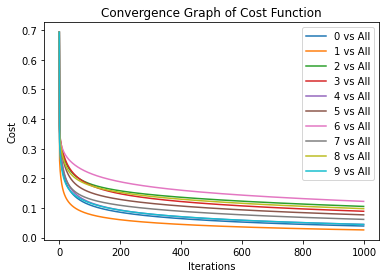

Training accuracy: 0.9445599445599445


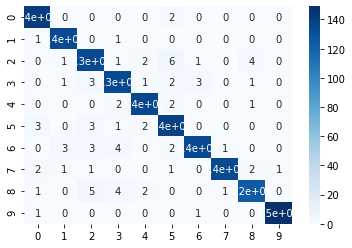

In [15]:
itrs = 1000
logreg = MyLogRegressor(lr=0.2, itrs=itrs).fit_onevsall(X_norm_train, y_train_lab)
logreg.plot_cost_ovr()

myscore1 = logreg.cal_score_ovr(X_norm_train,y_train_lab)
y_pred1 = logreg.predict_ovr(X_norm_train)
print("Training accuracy:",myscore1)
conf_mat1 = confusion_matrix(y_train_lab, y_pred1)
df_cm1 = pd.DataFrame(conf_mat1, index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure()
sn.heatmap(df_cm1, annot=True, cmap='Blues')

One vs All: Score and confusion matrix of test set

Testing accuracy: 0.7512116316639742


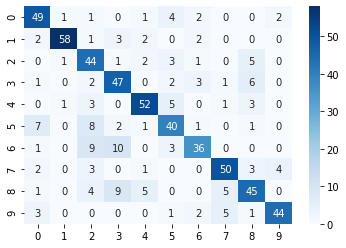

In [9]:
myscore2 = logreg.cal_score_ovr(X_norm_test,y_test_lab)
y_pred2 = logreg.predict_ovr(X_norm_test)
print("Testing accuracy:",myscore2)
conf_mat2 = confusion_matrix(y_test_lab, y_pred2)
df_cm2 = pd.DataFrame(conf_mat2, index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure()
sn.heatmap(df_cm2, annot=True, cmap='Blues')

One vs One: Score and confusion matrix of training set

Training model 0 : 0 vs 1
Training model 1 : 0 vs 2
Training model 2 : 0 vs 3
Training model 3 : 0 vs 4
Training model 4 : 0 vs 5
Training model 5 : 0 vs 6
Training model 6 : 0 vs 7
Training model 7 : 0 vs 8
Training model 8 : 0 vs 9
Training model 9 : 1 vs 2
Training model 10 : 1 vs 3
Training model 11 : 1 vs 4
Training model 12 : 1 vs 5
Training model 13 : 1 vs 6
Training model 14 : 1 vs 7
Training model 15 : 1 vs 8
Training model 16 : 1 vs 9
Training model 17 : 2 vs 3
Training model 18 : 2 vs 4
Training model 19 : 2 vs 5
Training model 20 : 2 vs 6
Training model 21 : 2 vs 7
Training model 22 : 2 vs 8
Training model 23 : 2 vs 9
Training model 24 : 3 vs 4
Training model 25 : 3 vs 5
Training model 26 : 3 vs 6
Training model 27 : 3 vs 7
Training model 28 : 3 vs 8
Training model 29 : 3 vs 9
Training model 30 : 4 vs 5
Training model 31 : 4 vs 6
Training model 32 : 4 vs 7
Training model 33 : 4 vs 8
Training model 34 : 4 vs 9
Training model 35 : 5 vs 6
Training model 36 : 5 vs 7
Training mo

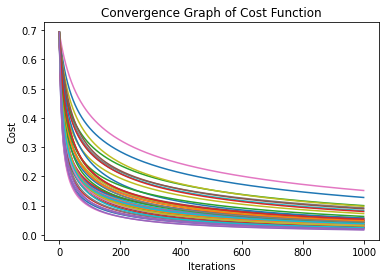

Training accuracy: 0.9466389466389467


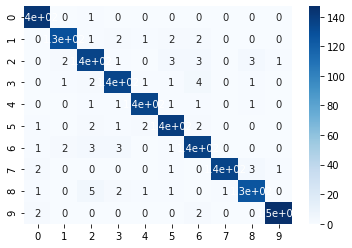

In [16]:
itrs = 1000
logreg = MyLogRegressor(lr=0.2, itrs=itrs).fit_onevsone(X_norm_train, y_train_lab)
logreg.plot_cost_ovo()

myscore1 = logreg.cal_score_ovo(X_norm_train,y_train_lab)
y_pred1 = logreg.predict_ovo(X_norm_train)
print("Training accuracy:",myscore1)
conf_mat1 = confusion_matrix(y_train_lab, y_pred1)
df_cm1 = pd.DataFrame(conf_mat1, index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure()
sn.heatmap(df_cm1, annot=True, cmap='Blues')



One vs One: Score and confusion matrix of training set

Testing accuracy: 0.7641357027463651


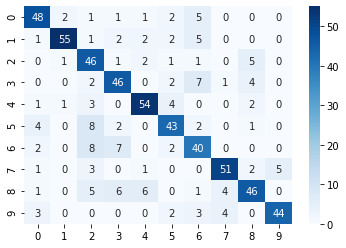

In [12]:
myscore2 = logreg.cal_score_ovo(X_norm_test,y_test_lab)
y_pred2 = logreg.predict_ovo(X_norm_test)
print("Testing accuracy:",myscore2)
conf_mat2 = confusion_matrix(y_test_lab, y_pred2)
df_cm2 = pd.DataFrame(conf_mat2, index = [i for i in range(10)], columns = [i for i in range(10)])
plt.figure()
sn.heatmap(df_cm2, annot=True, cmap='Blues')

Score for Sklearn's Logistic regression

In [13]:
clf = LogisticRegression(random_state=1,max_iter=1000).fit(X_norm_train, y_train_lab)
sk_score = clf.score(X_norm_test, y_test_lab)
print(sk_score)

0.7415185783521809
